In [ ]:
from google.colab import drive
drive.mount('/content/drive_mount')

Drive already mounted at /content/drive_mount; to attempt to forcibly remount, call drive.mount("/content/drive_mount", force_remount=True).


In [ ]:
import zipfile
import os

zip_filename = "/content/drive_mount/MyDrive/predictive_maintenance/microsoft-azure-predictive-maintenance.zip"

extract_dir = "/content/drive_mount/MyDrive/predictive_maintenance/maintenance_data"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

os.listdir(extract_dir)


['PdM_errors.csv',
 'PdM_failures.csv',
 'PdM_maint.csv',
 'PdM_machines.csv',
 'PdM_telemetry.csv']

In [ ]:
!pip install -q pandas numpy scikit-learn matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import joblib
from google.colab import files
import zipfile
import os


In [ ]:
file_paths = {
    'telemetry': f'{extract_dir}/PdM_telemetry.csv',
    'errors': f'{extract_dir}/PdM_errors.csv',
    'maint': f'{extract_dir}/PdM_maint.csv',
    'failures': f'{extract_dir}/PdM_failures.csv',
    'machines': f'{extract_dir}/PdM_machines.csv',
}

telemetry = pd.read_csv(file_paths['telemetry'], parse_dates=['datetime'])
errors = pd.read_csv(file_paths['errors'], parse_dates=['datetime'])
maintenance = pd.read_csv(file_paths['maint'], parse_dates=['datetime'])
failures = pd.read_csv(file_paths['failures'], parse_dates=['datetime'])
machines = pd.read_csv(file_paths['machines'])


In [ ]:
print("================Telemetry==================\n")
print(telemetry.head())
print("\n\n================Errors==================\n")
print(errors.head())
print("\n\n================Maintenance==================\n")
print(maintenance.head())
print("\n\n================Failures==================\n")
print(failures.head())
print("\n\n================Machines==================\n")
print(machines.head())

================Telemetry==================

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511  


================Errors==================

             datetime  machineID errorID
0 2015-01-03 07:00:00          1  error1
1 2015-01-03 20:00:00          1  error3
2 2015-01-04 06:00:00          1  error5
3 2015-01-10 15:00:00          1  error4
4 2015-01-22 10:00:00          1  error4


================Maintenance==================

             datetime  machineID   comp
0 2014-06-01 06:00:00          1  comp2
1 2014-07-16 

In [ ]:
# Tri des données temporelles
telemetry = telemetry.sort_values(by=['machineID', 'datetime']).reset_index(drop=True)
print("================Telemetry Tri==================\n")
print(telemetry.head())
# Merge avec les métadonnées des machines
telemetry = pd.merge(telemetry, machines, on='machineID', how='left')

print("\n\n================Telemetry & Machine==================\n")
print(telemetry.head())

================Telemetry Tri==================

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511  


================Telemetry & Machine==================

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-0

In [ ]:
PREDICTION_HORIZON = pd.Timedelta(hours=24)
telemetry['failure'] = 0
telemetry['RUL'] = np.nan

failure_map = failures.groupby('machineID')['datetime'].apply(list).to_dict()

for machine_id in telemetry['machineID'].unique():
    failure_times = sorted(failure_map.get(machine_id, []))
    for idx in telemetry[telemetry['machineID'] == machine_id].index:
        current_time = telemetry.loc[idx, 'datetime']
        next_failure = next((ft for ft in failure_times if ft > current_time), None)
        if next_failure:
            diff = (next_failure - current_time).total_seconds() / 3600
            telemetry.at[idx, 'RUL'] = diff
            if diff <= 24:
                telemetry.at[idx, 'failure'] = 1

print("\n\n================Telemetry & Machine & Failure & RUL==================\n")
print(telemetry.head())

# Supprimer les lignes sans RUL (pas de panne future connue)
telemetry.dropna(subset=['RUL'], inplace=True)

print("\n\n================Telemetry & Machine & Failure & RUL==================\n")
print(telemetry.head())





================Telemetry & Machine & Failure & RUL==================

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration   model  age  failure   RUL  
0  45.087686  model3   18        0  96.0  
1  43.413973  model3   18        0  95.0  
2  34.178847  model3   18        0  94.0  
3  41.122144  model3   18        0  93.0  
4  25.990511  model3   18        0  92.0  


================Telemetry & Machine & Failure & RUL==================

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:

In [ ]:
telemetry.head()
telemetry.tail()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,failure,RUL
875542,2015-12-09 01:00:00,100,191.563829,402.510934,89.586774,37.662014,model4,5,1,5.0
875543,2015-12-09 02:00:00,100,154.764808,362.514598,88.304637,33.997760,model4,5,1,4.0
875544,2015-12-09 03:00:00,100,169.520950,386.937494,110.906433,41.636435,model4,5,1,3.0
875545,2015-12-09 04:00:00,100,161.175695,422.498178,90.986648,44.406312,model4,5,1,2.0
875546,2015-12-09 05:00:00,100,182.762004,388.960329,114.030188,39.135241,model4,5,1,1.0


In [ ]:
features = ['volt', 'rotate', 'pressure', 'vibration']
windows = [3, 24, 48]

for feature in features:
    for w in windows:
        telemetry[f'{feature}_mean_{w}h'] = telemetry.groupby('machineID')[feature].transform(
            lambda x: x.rolling(window=w, min_periods=1).mean()
        )
        telemetry[f'{feature}_std_{w}h'] = telemetry.groupby('machineID')[feature].transform(
            lambda x: x.rolling(window=w, min_periods=1).std()
        )

# Remplissage des NaN
telemetry.bfill(inplace=True)
telemetry.ffill(inplace=True)



In [ ]:
print("\n\n================Telemetry in multiple marges==================\n")
print(telemetry.head())




================Telemetry in multiple marges==================

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration   model  age  failure   RUL  ...  pressure_mean_24h  \
0  45.087686  model3   18        0  96.0  ...         113.077935   
1  43.413973  model3   18        0  95.0  ...         104.269230   
2  34.178847  model3   18        0  94.0  ...          94.592122   
3  41.122144  model3   18        0  93.0  ...          98.256232   
4  25.990511  model3   18        0  92.0  ...         100.982315   

   pressure_std_24h  pressure_mean_48h  pressure_std_48h  vibration_mean_3h  \
0         12.

In [ ]:
errors['error'] = 1
error_count = errors.groupby(['machineID', 'datetime']).size().reset_index(name='error_count')
telemetry = pd.merge(telemetry, error_count, on=['machineID', 'datetime'], how='left')
telemetry['error_count'] = telemetry['error_count'].fillna(0)

for w in windows:
    telemetry[f'error_sum_{w}h'] = telemetry.groupby('machineID')['error_count'].transform(
        lambda x: x.rolling(window=w, min_periods=1).sum()
    )


In [ ]:
print("\n\n================Telemetry and Errors==================\n")
print(telemetry.head())




================Telemetry and Errors==================

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration   model  age  failure   RUL  ...  vibration_mean_3h  \
0  45.087686  model3   18        0  96.0  ...          45.087686   
1  43.413973  model3   18        0  95.0  ...          44.250829   
2  34.178847  model3   18        0  94.0  ...          40.893502   
3  41.122144  model3   18        0  93.0  ...          39.571655   
4  25.990511  model3   18        0  92.0  ...          33.763834   

   vibration_std_3h  vibration_mean_24h  vibration_std_24h  \
0          1.183494           45.08768

In [ ]:
components = ['comp1', 'comp2', 'comp3', 'comp4']

for comp in components:
    telemetry[f'time_since_last_maint_{comp}'] = 999999

for machine_id in telemetry['machineID'].unique():
    for comp in components:
        maint_times = maintenance[
            (maintenance['machineID'] == machine_id) &
            (maintenance['comp'] == comp)
        ].sort_values(by='datetime')['datetime'].tolist()

        if not maint_times:
            continue

        for idx in telemetry[telemetry['machineID'] == machine_id].index:
            t = telemetry.loc[idx, 'datetime']
            prev_maint = [mt for mt in maint_times if mt <= t]
            if prev_maint:
                diff = (t - prev_maint[-1]).total_seconds() / 3600
                telemetry.loc[idx, f'time_since_last_maint_{comp}'] = diff


KeyboardInterrupt: 

In [ ]:
print("\n\n================Telemetry and Last Maintenance==================\n")
print(telemetry.head())




================Telemetry and Last Maintenance==================

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration   model  age  failure   RUL  ...  vibration_mean_48h  \
0  45.087686  model3   18        0  96.0  ...           45.087686   
1  43.413973  model3   18        0  95.0  ...           44.250829   
2  34.178847  model3   18        0  94.0  ...           40.893502   
3  41.122144  model3   18        0  93.0  ...           40.950662   
4  25.990511  model3   18        0  92.0  ...           37.958632   

   vibration_std_48h  error_count  error_sum_3h  error_sum_24h  error_sum_48h  \
0  

In [ ]:
telemetry = pd.get_dummies(telemetry, columns=['model'], prefix='model')
final_df = telemetry.copy()

features_to_exclude = ['datetime', 'machineID', 'RUL', 'failure']
X = final_df.drop(columns=features_to_exclude)
y = final_df['failure']


In [ ]:
print(X)
print("==================================================")
print("==================================================")
print("==================================================")
print(y)

              volt      rotate    pressure  vibration  age  volt_mean_3h  \
0       176.217853  418.504078  113.077935  45.087686   18    176.217853   
1       162.879223  402.747490   95.460525  43.413973   18    169.548538   
2       170.989902  527.349825   75.237905  34.178847   18    170.028993   
3       162.462833  346.149335  109.248561  41.122144   18    165.443986   
4       157.610021  435.376873  111.886648  25.990511   18    163.687586   
...            ...         ...         ...        ...  ...           ...   
755251  191.563829  402.510934   89.586774  37.662014    5    172.657273   
755252  154.764808  362.514598   88.304637  33.997760    5    175.173794   
755253  169.520950  386.937494  110.906433  41.636435    5    171.949862   
755254  161.175695  422.498178   90.986648  44.406312    5    161.820484   
755255  182.762004  388.960329  114.030188  39.135241    5    171.152883   

        volt_std_3h  volt_mean_24h  volt_std_24h  volt_mean_48h  ...  \
0          9.43

In [ ]:
split_date = pd.Timestamp('2015-08-01 06:00:00')
train_idx = final_df['datetime'] < split_date
test_idx = final_df['datetime'] >= split_date

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


In [ ]:
model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

Accuracy: 0.9992527526153658
Precision: 0.982728337236534
Recall: 0.9885159010600707
F1: 0.9856136230182032
ROC AUC: 0.9998926081551115


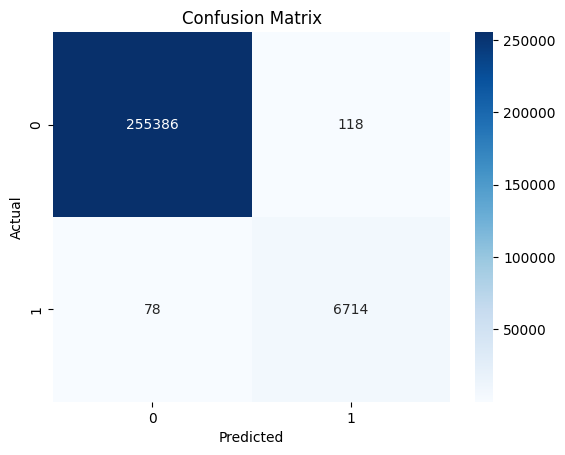

In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

conf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
model_filename = os.path.join('/content/drive_mount/MyDrive/predictive_maintenance/', 'predictive_maintenance_model_final.joblib') # Assurez-vous que BASE_DRIVE_PATH est défini
joblib.dump(model, model_filename)
print("Model saved successfully.")


Model saved successfully.


In [ ]:
import numpy as np

if 'y_test' in locals():
    failure_rate_in_test_set = y_test.mean()
    print(f"Taux de défaillance réel dans l'ensemble de test (proportion de '1's): {failure_rate_in_test_set:.6f}")
    if failure_rate_in_test_set < 0.001: # Si c'est moins de 0.1%
        print("Le taux de défaillance dans l'ensemble de test est très faible.")
        print("Il est normal que le modèle prédise peu ou pas de défaillances si la réalité est qu'il y en a très peu.")
else:
    print("Erreur : 'y_test' n'est pas défini. Assurez-vous d'avoir exécuté le script d'entraînement complet.")



Taux de défaillance réel dans l'ensemble de test (proportion de '1's): 0.025894


In [ ]:
import pandas as pd
import numpy as np
import joblib
import os
from datetime import timedelta
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score # Ajout si vous réévaluez ici

print("Libraries imported successfully.")

if not os.path.exists('/content/drive_mount'):
    print("Mounting Google Drive...")
    try:
        drive.mount('/content/drive_mount')
        print("Google Drive mounted successfully.")
    except Exception as e:
        print(f"Error mounting Google Drive: {e}")
        print("Please ensure you authorize Google Drive access when prompted.")
        raise e

BASE_DRIVE_PATH = '/content/drive_mount/MyDrive/predictive_maintenance/'

file_paths = {
    'telemetry': os.path.join(BASE_DRIVE_PATH, 'maintenance_data/PdM_telemetry.csv'),
    'errors': os.path.join(BASE_DRIVE_PATH, 'maintenance_data/PdM_errors.csv'),
    'maint': os.path.join(BASE_DRIVE_PATH, 'maintenance_data/PdM_maint.csv'),
    'failures': os.path.join(BASE_DRIVE_PATH, 'maintenance_data/PdM_failures.csv'),
    'machines': os.path.join(BASE_DRIVE_PATH, 'maintenance_data/PdM_machines.csv')
}

PREDICTION_HORIZON_HOURS = 24
TRAIN_TEST_SPLIT_DATE = pd.Timestamp('2015-08-01 06:00:00') # Convertir en Timestamp ici

print(f"Configuration loaded: Prediction Horizon = {PREDICTION_HORIZON_HOURS} hours")

Libraries imported successfully.
Configuration loaded: Prediction Horizon = 24 hours


In [ ]:
def preprocess_data(telemetry_df_raw, errors_df_raw, maint_df_raw, machines_df_raw, failures_df_raw=None, prediction_horizon_hours=24, is_training_phase=False):
    """
    Applique toutes les étapes de prétraitement et d'ingénierie des caractéristiques
    à un DataFrame de télémétrie.

    Args:
        telemetry_df_raw (pd.DataFrame): DataFrame de télémétrie brute.
        errors_df_raw (pd.DataFrame): DataFrame d'erreurs brutes.
        maint_df_raw (pd.DataFrame): DataFrame de maintenance brute.
        machines_df_raw (pd.DataFrame): DataFrame des métadonnées machines brutes.
        failures_df_raw (pd.DataFrame, optional): DataFrame des défaillances brutes. Requis si is_training_phase est True
                                                   ou si la colonne 'label_fail' est nécessaire.
        prediction_horizon_hours (int): Horizon de prédiction en heures pour le calcul de 'label_fail'.
        is_training_phase (bool): True si c'est la phase d'entraînement (calcul de RUL/label_fail et dropna).

    Returns:
        pd.DataFrame: DataFrame avec toutes les caractéristiques ingénierées.
    """
    print("Starting feature engineering...")

    # Assurer que les colonnes datetime sont au bon format
    for df_arg in [telemetry_df_raw, errors_df_raw, maint_df_raw, failures_df_raw]:
        if df_arg is not None and 'datetime' in df_arg.columns and not pd.api.types.is_datetime64_any_dtype(df_arg['datetime']):
            df_arg['datetime'] = pd.to_datetime(df_arg['datetime'])

    df_processed = telemetry_df_raw.copy()

    # 1. Fusionner les métadonnées de la machine
    df_processed = pd.merge(df_processed, machines_df_raw, on='machineID', how='left')
    df_processed = df_processed.sort_values(by=['machineID', 'datetime']).reset_index(drop=True)

    # 2. Ajouter les fonctionnalités décalées (moyennes/écarts-types glissants)
    telemetry_numerical_features = ['volt', 'rotate', 'pressure', 'vibration']
    window_sizes = [3, 24, 48]

    for feature in telemetry_numerical_features:
        for window in window_sizes:
            df_processed[f'{feature}_mean_{window}h'] = df_processed.groupby('machineID')[feature].rolling(
                window=window, min_periods=1
            ).mean().reset_index(level=0, drop=True)
            df_processed[f'{feature}_std_{window}h'] = df_processed.groupby('machineID')[feature].rolling(
                window=window, min_periods=1
            ).std().reset_index(level=0, drop=True)

    # Remplir les NaN résultant des fenêtres glissantes au début
    df_processed.bfill(inplace=True)
    df_processed.ffill(inplace=True)

    # 3. Traiter les comptes d'erreurs
    error_counts = errors_df_raw.groupby(['machineID', 'datetime']).size().reset_index(name='hourly_error_count')
    df_processed = pd.merge(df_processed, error_counts, on=['machineID', 'datetime'], how='left')
    df_processed['hourly_error_count'] = df_processed['hourly_error_count'].fillna(0)

    for window in window_sizes:
        df_processed[f'error_count_sum_{window}h'] = df_processed.groupby('machineID')['hourly_error_count'].rolling(
            window=window, min_periods=1
        ).sum().reset_index(level=0, drop=True)
    df_processed.bfill(inplace=True)
    df_processed.ffill(inplace=True)

    # 4. Traiter l'historique de maintenance (temps depuis la dernière maintenance)
    maint_df_sorted = maint_df_raw.sort_values(by=['machineID', 'datetime']).reset_index(drop=True)
    components = ['comp1', 'comp2', 'comp3', 'comp4']

    for comp in components:
        df_processed[f'time_since_last_maint_{comp}'] = np.nan

    for machine_id in df_processed['machineID'].unique():
        machine_telemetry_indices = df_processed[df_processed['machineID'] == machine_id].index
        machine_maint_records = maint_df_sorted[maint_df_sorted['machineID'] == machine_id].copy()

        for idx in machine_telemetry_indices:
            current_telemetry_time = df_processed.loc[idx, 'datetime']
            relevant_maint = machine_maint_records[machine_maint_records['datetime'] <= current_telemetry_time]

            if not relevant_maint.empty:
                for comp in components:
                    last_maint_time_for_comp = relevant_maint[relevant_maint['comp'] == comp]['datetime'].max()
                    if pd.notna(last_maint_time_for_comp):
                        time_diff_hours = (current_telemetry_time - last_maint_time_for_comp).total_seconds() / 3600
                        df_processed.loc[idx, f'time_since_last_maint_{comp}'] = time_diff_hours
                    else:
                        df_processed.loc[idx, f'time_since_last_maint_{comp}'] = 999999
    for comp in components:
        df_processed[f'time_since_last_maint_{comp}'].fillna(999999, inplace=True)

    # 5. Gérer les fonctionnalités catégorielles ('model')
    df_processed = pd.get_dummies(df_processed, columns=['model'], prefix='model')

    # 6. Calculer RUL et la variable cible 'label_fail' (uniquement en phase d'entraînement ou si demandé)
    if is_training_phase or (failures_df_raw is not None and 'label_fail' not in df_processed.columns):
        if 'RUL' not in df_processed.columns: df_processed['RUL'] = np.nan
        if 'label_fail' not in df_processed.columns: df_processed['label_fail'] = 0

        if failures_df_raw is not None:
            machine_failure_times = failures_df_raw.groupby('machineID')['datetime'].apply(list).to_dict()
            for machine_id in df_processed['machineID'].unique():
                machine_indices = df_processed[df_processed['machineID'] == machine_id].index
                failures_for_machine = sorted(machine_failure_times.get(machine_id, []))
                if not failures_for_machine: continue

                for idx in machine_indices:
                    current_time = df_processed.loc[idx, 'datetime']
                    next_failure_time = None
                    for f_time in failures_for_machine:
                        if f_time > current_time:
                            next_failure_time = f_time
                            break
                    if next_failure_time:
                        rul_hours = (next_failure_time - current_time).total_seconds() / 3600
                        df_processed.loc[idx, 'RUL'] = rul_hours
                        if rul_hours <= prediction_horizon_hours:
                            df_processed.loc[idx, 'label_fail'] = 1
        if is_training_phase:
            df_processed.dropna(subset=['RUL'], inplace=True) # En phase d'entraînement, on enlève les lignes sans RUL

    print("Feature engineering complete.")
    return df_processed

In [ ]:
# Charger les DataFrames bruts
print("Loading all raw data for feature engineering...")
try:
    telemetry_df_raw = pd.read_csv(file_paths['telemetry'])
    errors_df_raw = pd.read_csv(file_paths['errors'])
    maint_df_raw = pd.read_csv(file_paths['maint'])
    failures_df_raw = pd.read_csv(file_paths['failures'])
    machines_df_raw = pd.read_csv(file_paths['machines'])
    print("All raw data loaded successfully.")

    # Convertir les colonnes 'datetime' en objets datetime (si non déjà fait par la fonction preprocess_data)
    for df_arg in [telemetry_df_raw, errors_df_raw, maint_df_raw, failures_df_raw]:
        if 'datetime' in df_arg.columns and not pd.api.types.is_datetime64_any_dtype(df_arg['datetime']):
            df_arg['datetime'] = pd.to_datetime(df_arg['datetime'])

except FileNotFoundError as e:
    print(f"Error: One or more raw CSV files not found. Please check your 'file_paths' configuration and Google Drive setup.")
    print(f"Missing file: {e.filename}")
    raise e # Arrête l'exécution si les fichiers de base ne sont pas trouvés

Loading all raw data for feature engineering...
All raw data loaded successfully.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

print("\n--- Phase d'Entraînement du Modèle ---")

# Appliquer le feature engineering sur l'ensemble complet des données d'entraînement
# Note: La fonction `preprocess_data` gère le tri et les conversions datetime si elles ne sont pas faites
# Utilisez une copie des brutes pour ne pas modifier les originaux
df_processed_full = preprocess_data(
    telemetry_df_raw.copy(), errors_df_raw.copy(), maint_df_raw.copy(), machines_df_raw.copy(),
    failures_df_raw=failures_df_raw.copy(), # Passer les pannes ici pour le calcul de RUL/label_fail
    prediction_horizon_hours=PREDICTION_HORIZON_HOURS,
    is_training_phase=True # Indique que nous sommes en phase d'entraînement
)

print(f"Shape of fully processed data for training: {df_processed_full.shape}")
print(f"Sample of processed data features for training:\n{df_processed_full.head()}")

# Division train/test chronologique
train_df_full = df_processed_full[df_processed_full['datetime'] < TRAIN_TEST_SPLIT_DATE]
test_df_full = df_processed_full[df_processed_full['datetime'] >= TRAIN_TEST_SPLIT_DATE]

# Définir X et y pour l'entraînement
features_to_exclude = ['datetime', 'machineID', 'RUL', 'label_fail'] # 'failure' est devenu 'label_fail'
X_train_full = train_df_full.drop(columns=features_to_exclude, errors='ignore')
y_train_full = train_df_full['label_fail']

# Enregistrer les noms de colonnes d'entraînement (nouvelle bonne pratique)
X_train_columns = X_train_full.columns.tolist()
joblib.dump(X_train_columns, os.path.join(BASE_DRIVE_PATH, 'X_train_columns.joblib'))
print("X_train_columns saved successfully.")

# Entraîner le modèle
model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_full, y_train_full) # Utilisez X_train_full et y_train_full
print("Model trained successfully.")

# Sauvegarder le modèle
model_filename = os.path.join(BASE_DRIVE_PATH, 'predictive_maintenance_model_final.joblib')
joblib.dump(model, model_filename)
print(f"Model saved successfully to: {model_filename}")

# Métriques d'entraînement (optionnel, pour vérification rapide)
from sklearn.metrics import classification_report
y_pred_train = model.predict(X_train_full)
print("\nClassification Report on Training Data:")
print(classification_report(y_train_full, y_pred_train))


--- Phase d'Entraînement du Modèle ---
Starting feature engineering...


/tmp/ipython-input-10-773693894.py:85: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[f'time_since_last_maint_{comp}'].fillna(999999, inplace=True)


Feature engineering complete.
Shape of fully processed data for training: (755256, 45)
Sample of processed data features for training:
             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  age  volt_mean_3h  volt_std_3h  volt_mean_24h  ...  \
0  45.087686   18    176.217853     9.431836     176.217853  ...   
1  43.413973   18    169.548538     9.431836     169.548538  ...   
2  34.178847   18    170.028993     6.721032     170.028993  ...   
3  41.122144   18    165.443986     4.807415     168.137453  ...   
4  25.990511   18    163.687586     6.773501     166.031967  ...   

   time_since_last_main

In [ ]:
# --- Phase d'Inférence / Test du Modèle ---
print("\n--- Phase d'Inférence / Test du Modèle ---")



# Nom du fichier du modèle à charger
model_filename = os.path.join(BASE_DRIVE_PATH, 'predictive_maintenance_model_final.joblib')
# Nom du fichier des colonnes d'entraînement à charger
columns_filename = os.path.join(BASE_DRIVE_PATH, 'X_train_columns.joblib')

# Charger le Modèle Entraîné et les noms de colonnes
print(f"Loading the trained model from '{model_filename}'...")
try:
    loaded_model = joblib.load(model_filename)
    X_train_columns = joblib.load(columns_filename) # Charger les noms de colonnes
    print("Model and feature names loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: Model or feature names file not found. Ensure they were saved correctly.")
    print(f"Missing file: {e.filename}")
    exit() # Arrête l'exécution du script si les fichiers ne sont pas trouvés


# Préparer les Nouvelles Données pour la Prédiction (utilisation de la fonction)
print(f"\nPreparing new data for prediction (using data after {TRAIN_TEST_SPLIT_DATE})...")
# Utiliser les données brutes à partir de la date de split (simule les nouvelles données)
test_data_raw_subset = telemetry_df_raw[telemetry_df_raw['datetime'] >= TRAIN_TEST_SPLIT_DATE].copy()

if test_data_raw_subset.empty:
    print("No test data found after the split date. Cannot proceed with prediction.")
    exit()

# Appliquer la même ingénierie des fonctionnalités
# Passez des copies des df_raw pour éviter les SettingWithCopyWarning et préserver les originaux
df_processed_test = preprocess_data(
    test_data_raw_subset.copy(),
    errors_df_raw.copy(), # Il faut les données d'erreurs/maintenance complètes si les fenêtres glissantes vont au-delà de test_data_raw_subset
    maint_df_raw.copy(),
    machines_df_raw.copy(),
    failures_df_raw=failures_df_raw.copy(), # Toujours passer les pannes pour le calcul de RUL/label_fail pour l'évaluation
    prediction_horizon_hours=PREDICTION_HORIZON_HOURS,
    is_training_phase=False # En phase d'inférence, on ne dropna pas sur RUL/label_fail
)

print(f"Shape of processed test data for prediction: {df_processed_test.shape}")
print(f"Sample of processed test data features:\n{df_processed_test.head()}")


# Préparer le Jeu de Données de Prédiction Final
# Exclure les colonnes non-feature, y compris 'label_fail' pour X_test
features_to_exclude_pred = ['datetime', 'machineID', 'RUL', 'label_fail']
X_test_final = df_processed_test.drop(columns=features_to_exclude_pred, errors='ignore')

# Alignez les colonnes de X_test_final avec les colonnes d'entraînement
missing_cols_in_test = set(X_train_columns) - set(X_test_final.columns)
for c in missing_cols_in_test:
    X_test_final[c] = 0

# Assurez-vous que l'ordre des colonnes est le même
X_test_final = X_test_final[X_train_columns]
X_test_final.fillna(0, inplace=True) # Assurer qu'il n'y a pas de NaN résiduels

print(f"Final test data prepared with {X_test_final.shape[1]} features.")
print(f"Sample of final test features:\n{X_test_final.head()}")

# Faire des Prédictions
print("\nMaking predictions on the new data...")
predictions = loaded_model.predict(X_test_final)
probabilities = loaded_model.predict_proba(X_test_final)[:, 1]
print("Predictions made successfully.")

# --- 7. Interpréter et Évaluer les Résultats ---
print("\n--- Évaluation des Prédictions ---")

# Récupérer les vraies étiquettes pour l'évaluation (y_test_true)
# C'est la 'label_fail' de test_df_full ou df_processed_test si calculée
y_test_true = df_processed_test['label_fail']

print("Accuracy:", accuracy_score(y_test_true, predictions))
print("Precision:", precision_score(y_test_true, predictions))
print("Recall:", recall_score(y_test_true, predictions))
print("F1:", f1_score(y_test_true, predictions))
print("ROC AUC:", roc_auc_score(y_test_true, probabilities))

conf = confusion_matrix(y_test_true, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.title("Confusion Matrix on Test Set (Post-Split Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Visualisation des Probabilités ---
plt.figure(figsize=(10, 6))
sns.histplot(probabilities, bins=50, kde=True)
plt.title('Distribution des Probabilités de Défaillance Prédites (Ensemble de Test)')
plt.xlabel('Probabilité de Défaillance')
plt.ylabel('Nombre d\'Observations')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- Exemples de Prédictions ---
print("\n--- Sample Predictions and Probabilities ---")
sample_results = df_processed_test[['datetime', 'machineID', 'label_fail', 'RUL']].copy() # Inclure les vraies labels et RUL pour comparaison
sample_results['Predicted_Failure'] = predictions
sample_results['Failure_Probability'] = probabilities

print(sample_results.head(10))

print(f"\nTotal number of predicted failures (within {PREDICTION_HORIZON_HOURS} hours): {np.sum(predictions)}")
print(f"Average probability of failure: {np.mean(probabilities):.4f}")

predicted_failures_df = sample_results[sample_results['Predicted_Failure'] == 1]
if not predicted_failures_df.empty:
    print(f"\n--- Machines Predicted to Fail (Sample) ---")
    # Trier par probabilité décroissante pour voir les prédictions les plus confiantes
    print(predicted_failures_df.sort_values(by='Failure_Probability', ascending=False).head(10))
else:
    print("\nNo failures predicted in the test data within this horizon.")

print("\n--- How to Interpret the Results ---")
print(
    f"The 'Predicted_Failure' column indicates if the model predicts a failure within the next {PREDICTION_HORIZON_HOURS} hours (1 = Yes, 0 = No).")
print(
    f"The 'Failure_Probability' column gives the model's confidence in that prediction (closer to 1.0 means higher confidence in failure).")
print("You would typically use these predictions to trigger alerts or schedule proactive maintenance for machines with 'Predicted_Failure' = 1 and/or a high 'Failure_Probability'.")
print("For evaluation purposes, compare 'Predicted_Failure' with 'label_fail' (the true outcome).")

print("\nModel inference/testing complete.")


--- Phase d'Inférence / Test du Modèle ---


NameError: name 'os' is not defined

**AUTONOMIE AFTER SUVEGARDE DE MODELE**